# QM9 Dataset exploration

Partly inspired from the [chainer-chemistry example notebook](https://github.com/chainer/chainer-chemistry/blob/master/examples/qm9/qm9_dataset_exploration.ipynb).

The purpose of this notebook is as follows:

* Explain QM9 dataset: Check the labels and visualization of molecules to understand what kind of data are stored.
* Explain internal structure of QM9 dataset in chainer_chemistry.
* Perform a study on the effectiveness of Random Walk Positional Encodings (RWPEs) in capturing graph-level topology.

This notebook needs additional dependencies, install them with the cell below:

In [5]:
# !pip install chainer-chemistry rdkit networkx

In [14]:
# Imports necessary for running this notebook
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from itertools import count
from chainer_chemistry import datasets

QM9 dataset can be downloaded automatically by chainer chemistry. Original format of QM9 dataset is zipped file where each molecule's information is stored in each "xyz" file.

The dataset contains several chemical/physical properties. The labels of QM9 dataset can be checked by get_qm9_label_names method.

In [15]:
label_names = datasets.get_qm9_label_names()
print('QM9 label_names =', label_names)

QM9 label_names = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']


### Preprocessing dataset

Dataset extraction depends on the preprocessing method, which is determined by preprocessor. Here, we are using the `GGNNPreprocessor` preprocessor for QM9 dataset extraction. This will take approximately 4 minutes.

In [16]:
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import \
    GGNNPreprocessor
    
preprocessor = GGNNPreprocessor()
dataset, dataset_smiles = datasets.get_qm9(preprocessor, labels=None, return_smiles=True)

100%|██████████| 133885/133885 [03:37<00:00, 614.99it/s]


### Visualizing a molecule

In [17]:
# This script is referred from http://rdkit.blogspot.jp/2015/02/new-drawing-code.html
# and http://cheminformist.itmol.com/TEST/wp-content/uploads/2015/07/rdkit_moldraw2d_2.html
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg

def render_svg(svg):
    return SVG(svg.replace('svg:',''))

smiles: CC1=NCCC(C)O1


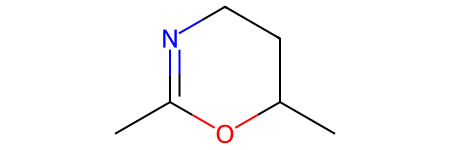

In [18]:
index = 7777
smiles = dataset_smiles[index]
mol = Chem.MolFromSmiles(dataset_smiles[index])

print('smiles:', smiles)
svg = moltosvg(mol)
render_svg(svg)

### RWPE studies


TODO: write some more things here

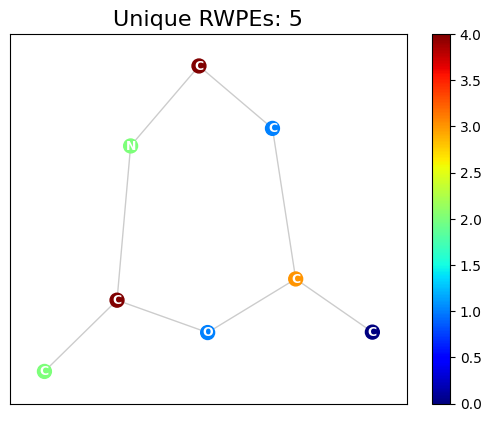

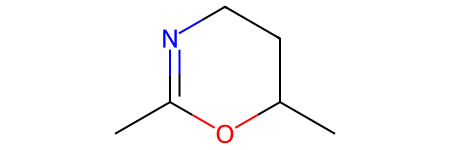

In [19]:
def rw_positoinal_encoding(adj_matrix, depth=24):
    # Calculate degree matrix as row vector
    degrees = np.sum(adj_matrix, axis=0)
    randomwalk_matrix = []
    
    # First random walk (n=1) is just adjacency matrix / degrees vector
    randomwalk_matrix.append(adj_matrix / degrees)

    # Conduct random walk for N steps
    for _ in range(depth-1):
        randomwalk_i = np.zeros(adj_matrix.shape)

        # Divide probabilities by number of outgoing edges
        values = (randomwalk_matrix[-1].T / degrees).T

        # Redistribute position probabilities by the edges
        for i in range(values.shape[0]):
            for j in range(values.shape[1]):
                col_vector = adj_matrix[:, j] * values[i, j]
                randomwalk_i[:, i] += col_vector

        randomwalk_matrix.append(randomwalk_i)

    diagonal_elements = np.array([np.diag(rw_matrix) for rw_matrix in randomwalk_matrix])
    return torch.from_numpy(diagonal_elements)

def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G

def plot_molecule_at(index, bond_type='single'):
    index_map = {'single':0, 'double':1, 'triple':2, 'aromatic':3}
    atom, adj, labels = dataset[index]
    smiles = dataset_smiles[index]
    mol = Chem.MolFromSmiles(dataset_smiles[index])
    
    g = mol_to_nx(mol)
    adj = adj[index_map[bond_type]]
    rw = rw_positoinal_encoding(adj)
    
    for i, n in enumerate(g.nodes()):
        g.nodes[n]['pos_enc'] = rw[:, i] 
    
    # Compute the number of unique RWPEs
    groups = torch.unique(rw, dim=1) 
    mapping = dict(zip(groups.T,count()))    
        
    nodes = g.nodes()
    colors, labels = [], {}
    for n in nodes:
        labels[n] = g.nodes[n]['atom_symbol']
        for key in mapping.keys():
            if torch.equal(key, g.nodes[n]['pos_enc']):
                color = mapping[key]
        colors.append(color)
    pos = nx.spring_layout(g)
    ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, 
                                node_size=100, cmap=plt.cm.jet)
    
    nx.draw_networkx_labels(g, pos, labels, font_size=9, font_color='w', font_weight='bold')
    plt.colorbar(nc)
    plt.title("Unique RWPEs: " + str(groups.shape[1]), fontsize=16)
    plt.show()    
    
    
index = 7777
plot_molecule_at(index)
smiles = dataset_smiles[index]
mol = Chem.MolFromSmiles(dataset_smiles[index])
rdDepictor.Compute2DCoords(mol)
svg = moltosvg(mol)
render_svg(svg)